# Elevation inpainting in selected region of Gamburtsev Subglacial Mountains

## ↓↓↓The framework of elevation inpainting.↓↓↓

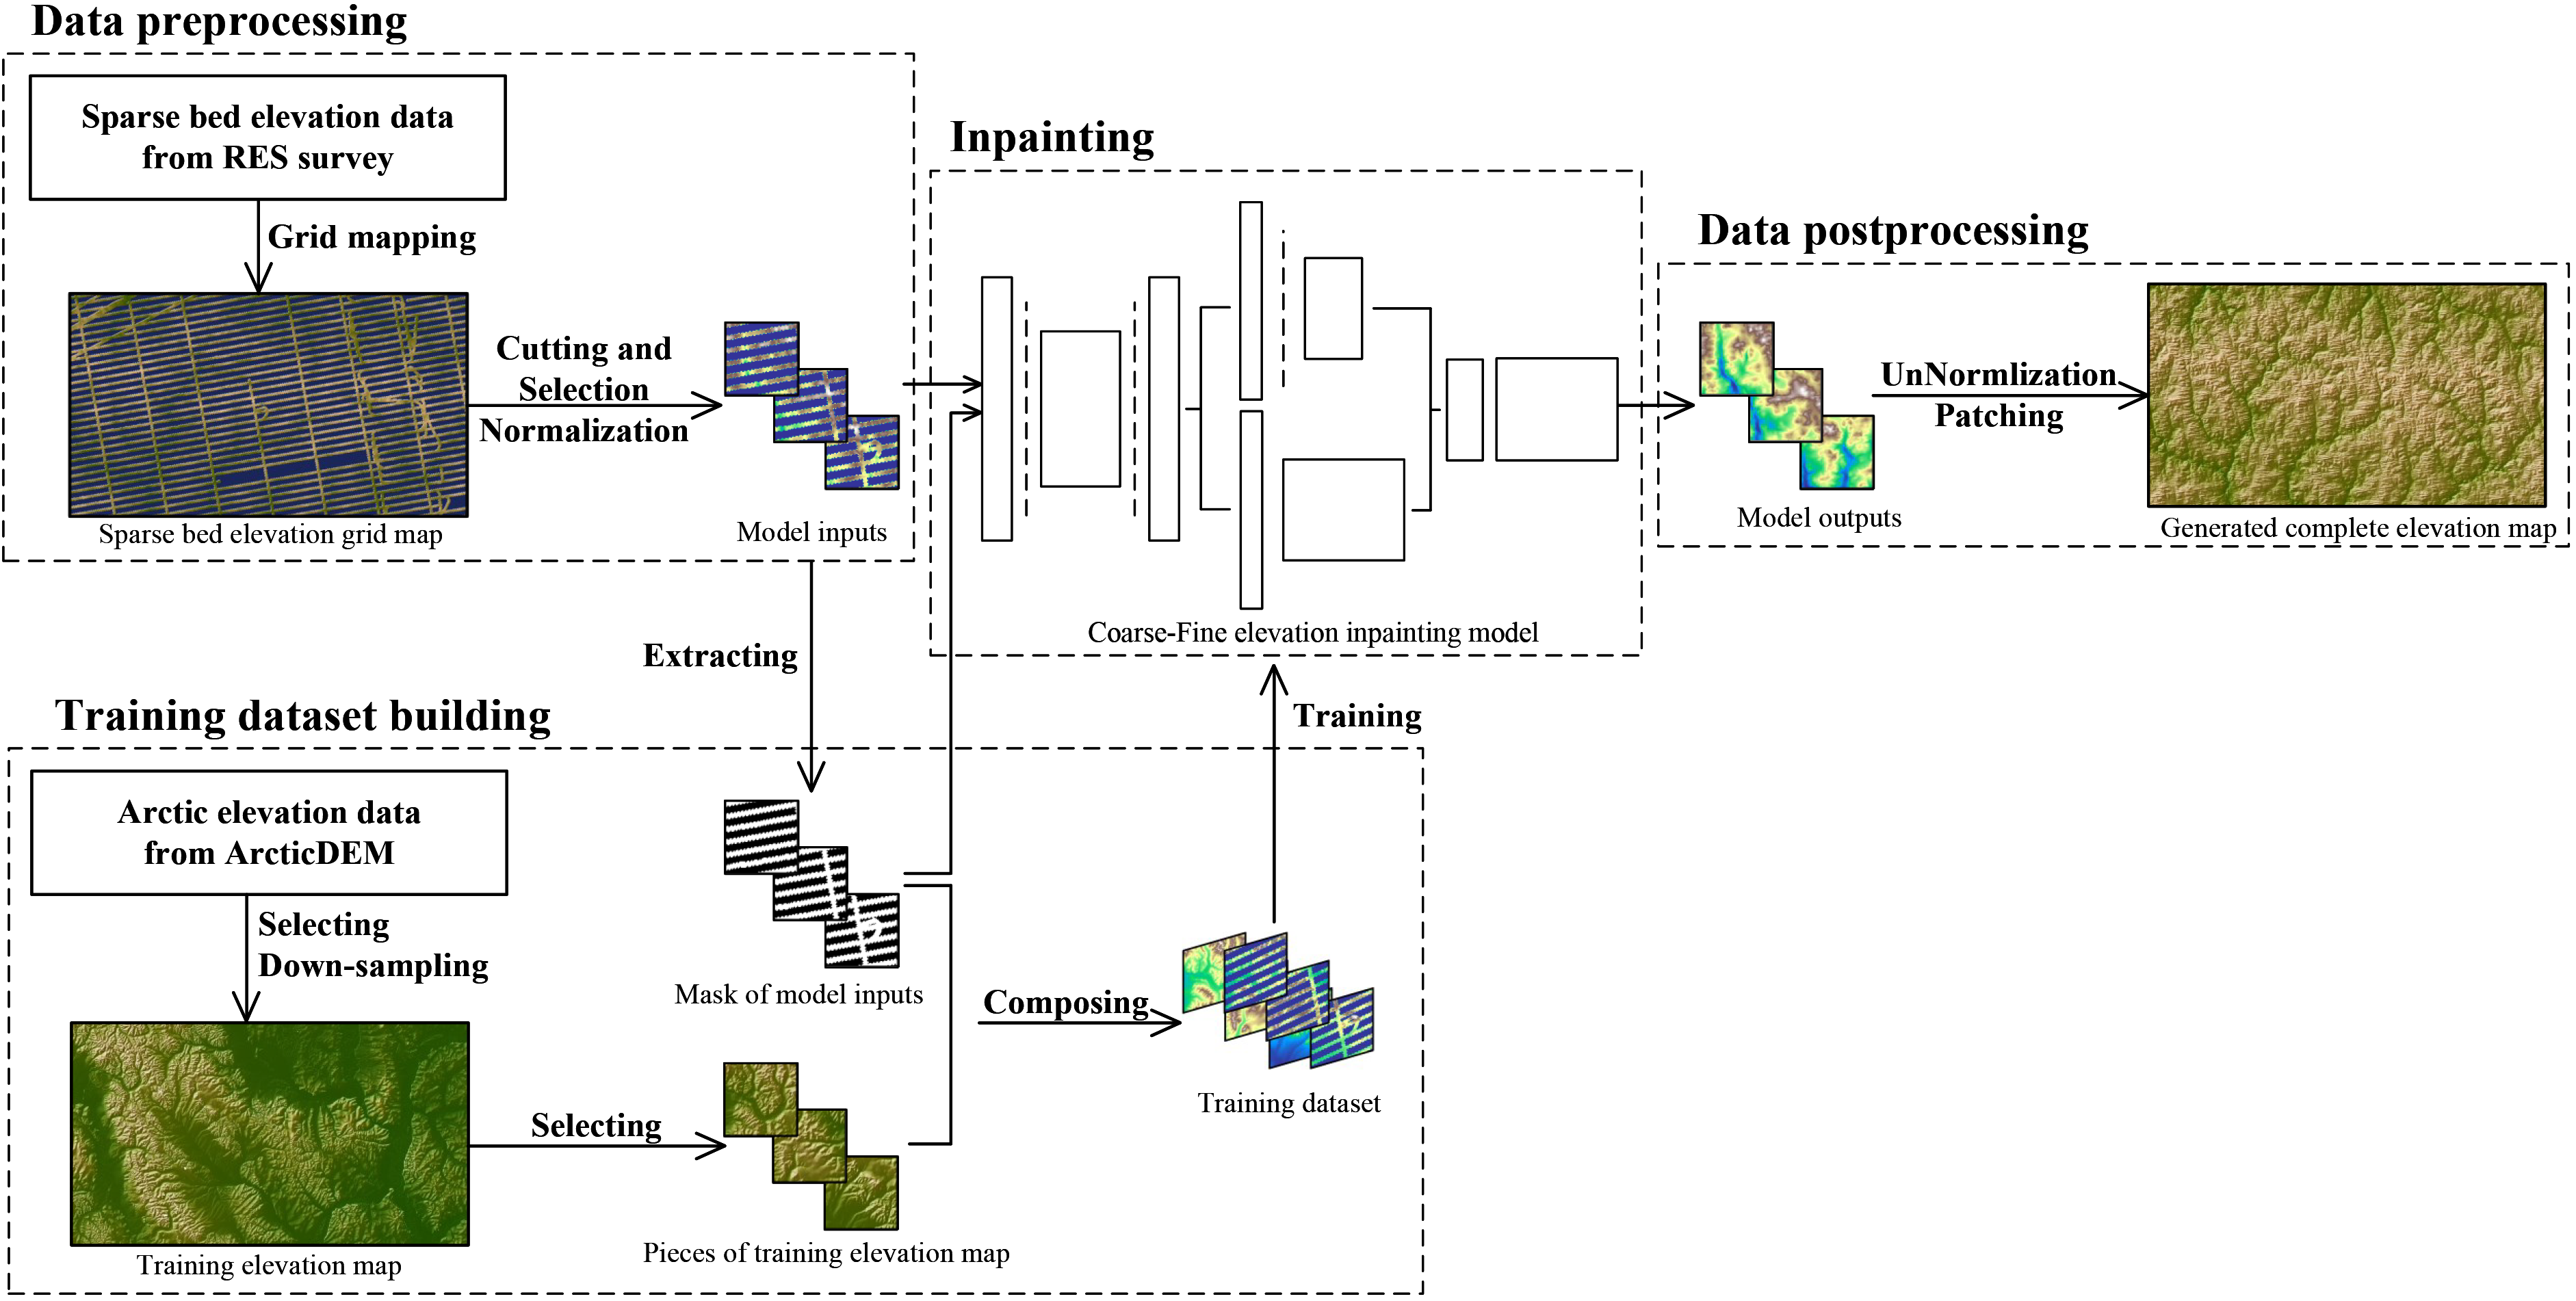

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import dataclasses
import math
import os
import xarray as xr
import salem
import geopandas as gpd
import pandas as pd
import quilt
import skimage
import pygmt
import pyproj
from tqdm import tqdm
from tools import *
from model import *

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

 ## 1.Data pre-processing

In [2]:
# Define constants

c_point = (970000, 250000)
resolution = 250
x_range = 20
y_range = 40
pad = 14
stride = 84
step = 112
EI_1_pad_region = rasterio.coords.BoundingBox(left=c_point[0]-y_range*stride*resolution/2-pad*250,
                                        bottom=c_point[1]-x_range*stride*resolution/2-pad*250,
                                        right=c_point[0]+y_range*stride*resolution/2+pad*250,
                                        top=c_point[1]+x_range*stride*resolution/2+pad*250)

EI_1_region = rasterio.coords.BoundingBox(left=c_point[0]-y_range*stride*resolution/2,
                                        bottom=c_point[1]-x_range*stride*resolution/2,
                                        right=c_point[0]+y_range*stride*resolution/2,
                                        top=c_point[1]+x_range*stride*resolution/2)
save_file = "data/EI_1"

In [3]:
# Load sparse xyz data

data1 = pd.read_csv('/home/user/files/yzj/Pro0119/data/xyz_data/TO_G.csv')
data2 = pd.read_csv('/home/user/files/yzj/Pro0119/data/xyz_data/AGAP-BAS.csv')
sparse_data = pd.merge(data1, data2, how='outer')
sparse_data = sparse_data[['x', 'y', 'z']].astype('float32')

In [4]:
sparse_data

x              y            z
0        5.837733e+05  133170.937500   671.983887
1        5.837748e+05  133186.828125   668.757324
2        5.837755e+05  133202.515625   665.519531
3        5.837770e+05  133218.390625   666.496826
4        5.837785e+05  133234.187500   654.798096
...               ...            ...          ...
4448930  1.082068e+06  112854.882812  1562.599976
4448931  1.082061e+06  112892.234375  1567.530029
4448932  1.082055e+06  112929.578125  1571.959961
4448933  1.082048e+06  112966.781250  1576.300049
4448934  1.082041e+06  113004.039062  1580.640015

[4448935 rows x 3 columns]

In [6]:
# Select data by region

region = EI_1_pad_region
selected_sparse_data = sparse_data
selected_sparse_data = selected_sparse_data[selected_sparse_data['x']>=region.left]
selected_sparse_data = selected_sparse_data[selected_sparse_data['x']<=region.right]
selected_sparse_data = selected_sparse_data[selected_sparse_data['y']>=region.bottom]
selected_sparse_data = selected_sparse_data[selected_sparse_data['y']<=region.top]
selected_sparse_data = selected_sparse_data.reset_index(drop=True)

In [7]:
selected_sparse_data

x              y            z
0        5.837733e+05  133170.937500   671.983887
1        5.837748e+05  133186.828125   668.757324
2        5.837755e+05  133202.515625   665.519531
3        5.837770e+05  133218.390625   666.496826
4        5.837785e+05  133234.187500   654.798096
...               ...            ...          ...
3354988  1.082068e+06  112854.882812  1562.599976
3354989  1.082061e+06  112892.234375  1567.530029
3354990  1.082055e+06  112929.578125  1571.959961
3354991  1.082048e+06  112966.781250  1576.300049
3354992  1.082041e+06  113004.039062  1580.640015

[3354993 rows x 3 columns]

In [9]:
# Map xyz data to grid data
data = selected_sparse_data
x_max = int((region.right-region.left)/resolution)
y_max = int((region.top-region.bottom)/resolution)
data_array = np.zeros((1, y_max, x_max))
for x in tqdm(range(x_max)):
    for y in range(y_max):
        data_piece = data
        data_piece = data_piece[(data_piece['x'] >= region.left + resolution * x)
                              & (data_piece['x'] <= region.left + resolution * (x+1))
                              & (data_piece['y'] >= region.bottom + resolution * y)
                              & (data_piece['y'] <= region.bottom + resolution * (y+1))]
        data_array[0][y_max-1 - y][x] = data_piece['z'].mean()
np.save(f"{save_file}/sparse_grid.npy", np.nan_to_num(data_array, nan=-9999))

100%|██████████| 3388/3388 [23:26:43<00:00, 24.91s/it]   


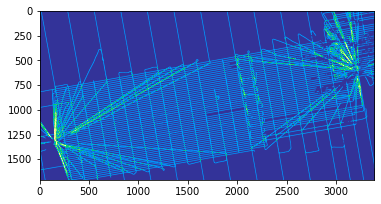

In [10]:
# sparse_grid = np.load(f"{save_file}/sparse_grid.npy")
plt.imshow((sparse_grid[0]>-9999), cmap='terrain')

In [12]:
# Keep a grid file that can be observed

save_array_to_grid(
    window_bound=EI_1_region,
    array=sparse_grid.astype(dtype=np.int16),
    outfilepath=f"{save_file}/sparse_grid",
    dtype=np.int16,
    tiled=True,
    compression=rasterio.enums.Compression.lzw.value,
)

In [13]:
# Cut grid image into pieces

sparse_grid_image = sparse_grid[0]
sparse_grid_image[sparse_grid_image==0]=-9999

array = np.expand_dims(np.expand_dims(sparse_grid_image, 0), 0)
for x in range(0, array.shape[2]-step+stride, stride):
    for y in range(0, array.shape[3]-step+stride, stride):
        if x is 0 and y is 0:
            crop_array = array[:, :, x:x+step, y:y+step]
        else: 
            crop_array = np.concatenate((crop_array, array[:, :, x:x+step, y:y+step]))
print(crop_array.shape)
np.save(f"{save_file}/crop_grid.npy", crop_array)

(800, 1, 112, 112)


In [14]:
# Calculate percentage of valid grid in each piece

array = crop_array
data_rate = []
for i in range(array.shape[0]):
    rate = ((array[i]>-9998).sum()) / array[i].size
    data_rate.append(rate)
data_rate

[0.010363520408163265,
 0.0,
 0.0,
 0.010283801020408163,
 0.0,
 0.0,
 0.01020408163265306,
 0.0,
 0.0,
 0.010363520408163265,
 0.0,
 0.0,
 0.010443239795918368,
 0.007095025510204082,
 0.0,
 0.009167729591836735,
 0.010522959183673469,
 0.0,
 0.00023915816326530612,
 0.010283801020408163,
 0.0,
 0.0,
 0.010443239795918368,
 0.0,
 0.0,
 0.010522959183673469,
 0.0,
 0.0,
 0.010363520408163265,
 0.008290816326530613,
 0.0,
 0.007174744897959184,
 0.01020408163265306,
 0.01650191326530612,
 0.04551977040816327,
 0.08721301020408163,
 0.06951530612244898,
 0.09550382653061225,
 0.06409438775510204,
 0.041294642857142856,
 0.010363520408163265,
 0.0,
 0.0,
 0.010443239795918368,
 0.0,
 0.0,
 0.010443239795918368,
 0.0,
 0.0,
 0.01020408163265306,
 0.006377551020408163,
 0.0,
 0.00980548469387755,
 0.010443239795918368,
 0.0,
 0.0012755102040816326,
 0.010443239795918368,
 0.0,
 0.0,
 0.010363520408163265,
 0.0,
 0.0,
 0.010363520408163265,
 0.0,
 0.0,
 0.010443239795918368,
 0.0069355867346

In [16]:
# Choose a threshold of pieces' valid grid percentage for generating

rate = 0.02
loc = []
for i in range(len(data_rate)):
    if data_rate[i] > rate:
        loc.append(i)
len(loc)
np.save(f"{save_file}/loc.npy", loc)

(1680, 3360)


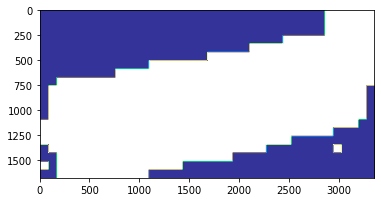

In [17]:
# Observe the selected generating area in this region

array = crop_array[:, :, pad:-pad, pad:-pad]

zeros_array = np.zeros((stride, stride))
ones_array = np.ones((stride, stride))

for x in range(x_range):
    for y in range(y_range):
        if x*y_range + y in loc:
            array = ones_array
        else:
            array = zeros_array
        if y == 0:
            array_y = array
        else:
            array_y = np.concatenate((array_y, array), 1)
    if x == 0:
        array_x_y = array_y
    else:
        array_x_y = np.concatenate((array_x_y, array_y), 0)
print(array_x_y.shape)
plt.imshow(array_x_y, cmap='terrain')

In [19]:
# Pick out the selected pieces

j = 0
for i in tqdm(loc):
    if j==0:
        sel_array = np.expand_dims(crop_array[i], 0)
        # print(sel_array.shape)
    else:
        sel_array = np.concatenate((sel_array, np.expand_dims(crop_array[i], 0)), 0)
    j = j + 1
np.save(f"{save_file}/sel_crop_{len(loc)}_rate_{rate}.npy", sel_array)
sel_array = np.nan_to_num(sel_array, 0)
sel_array.shape

100%|██████████| 490/490 [00:03<00:00, 137.33it/s] 


(490, 1, 112, 112)

## 2.Training dataset building

In [21]:
# Import cropped Arctic data (real data)

data = np.load("/home/user/files/yzj/GEI_2022/data/Y_train.npy")

In [22]:
# make custom masks

sel_data = sel_array
sel_data[sel_data==-9999]=0
mask_sel = (sel_data!=0)
mask_array = mask_sel
mask = np.concatenate((mask_array, mask_array, mask_array, mask_array,
                       mask_array, mask_array, mask_array, mask_array,
                       mask_array, mask_array, mask_array, mask_array,
                       ))
print(f"mask shape: {mask.shape}")

mask_2 = mask
a = np.arange(0, mask.shape[0], 1)
np.random.shuffle(a)
for i in range(len(a)):
    mask[i] = mask_2[a[i]]
print("average percentage of valid grid:", ((mask[:5218*2] != 0).sum()/(mask[:5218*2]!=-885).sum()))

mask shape: (5880, 1, 112, 112)
average percentage of valid grid: 0.07612040989865333


In [23]:
# Compose sparse grid data

x_data = data*mask[:5218]

In [24]:
np.save(f"{save_file}/x_train_data.npy", x_data)
np.save(f"{save_file}/y_train_data.npy", data)

## 3.Inpainting and data postprocessing

100%|██████████| 490/490 [00:09<00:00, 51.51it/s]


正在合成...
(1680, 3360)


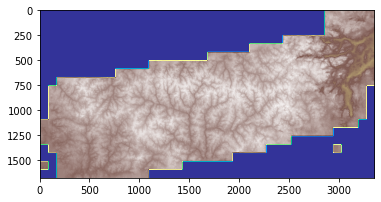

In [25]:
# Inpaint input pieces, unnormalized them, and patch them up

model_c = Coarse_Generator()
model_r = Refinement_Generator()

file_path = '/home/user/files/yzj/Pro220905/model/model_EI_1_Sun Aug  6 09:41:26 2022/epoch_207_mae_0.0000_0.0000'

model_c.load_state_dict(torch.load(f"{file_path}/generator_c.pth"))
model_r.load_state_dict(torch.load(f"{file_path}/generator_r.pth"))

model_c = nn.DataParallel(model_c).cuda()
model_r = nn.DataParallel(model_r).cuda()

mask_data = torch.tensor(np.load(f"{save_file}/sel_crop_490_rate_0.02.npy")).float()
mask_data = torch.tensor(np.nan_to_num(mask_data, 0))
mask_data[mask_data<-9998]=0

loc = np.load(f"{save_file}/loc.npy").tolist()
scale_rate = 1.5
batchs = []
batch_size = 1
for i in np.arange(0, mask_data.shape[0], batch_size):
    if i+batch_size < mask_data.shape[0]:
        batchs.append(mask_data[i:i+batch_size, :, :, :])
    else:
        batchs.append(mask_data[i:, :, :, :])
        
        
for i in tqdm(range(len(batchs))):
    
    lr = batchs[i].cuda()
    mask = (lr==0).float()
    
    lr_min = lr[lr!=0].min()
    lr_max = lr[lr!=0].max()
    lr_low = ((lr_max+lr_min) - (lr_max-lr_min)*scale_rate)/2
    lr_high = ((lr_max+lr_min) + (lr_max-lr_min)*scale_rate)/2
    lr_range = (lr_high - lr_low)

    LR = (lr-lr_low)/lr_range
    
    sr1 = model_c(LR, mask)
    sr = model_r(LR, mask, sr1)
    sr = sr.cpu().detach()
    SR = sr*lr_range + lr_low
    if i == 0:
        SR_crop = SR
    else:
        SR_crop = np.concatenate((SR_crop, SR), 0)


print("正在合成...")

data_array = SR_crop[:, :, pad:-pad, pad:-pad]
none_array = np.ones((stride, stride))*-9999
for x in range(x_range):
    for y in range(y_range):
        i = x*y_range + y
        if i in loc:
            array = data_array[loc.index(i)][0]
        else:
            array = none_array
        if y == 0:
            array_y = array
        else:
            array_y = np.concatenate((array_y, array), 1)
    if x == 0:
        array_x_y = array_y
    else:
        array_x_y = np.concatenate((array_x_y, array_y), 0)
print(array_x_y.shape)

plt.imshow(array_x_y, cmap='terrain')
plt.show()

In [26]:
# Save the result

name = 'result_EI_1_1'
save_array_to_grid(
    window_bound=EI_1_region,
    array=np.expand_dims(array_x_y, 0).astype(dtype=np.int16),
    outfilepath=f"{save_file}/result/{name}",
    dtype=np.int16,
    tiled=True,
    compression=rasterio.enums.Compression.lzw.value,  # Lempel-Ziv-Welch, lossless
)

/home/user/anaconda3/envs/DEEPMAP/lib/python3.7/site-packages/ipykernel_launcher.py:17: SyntaxWarning: Short-form parameter (Q) is not recommended. Use long-form parameter 'nan_transparent' instead.


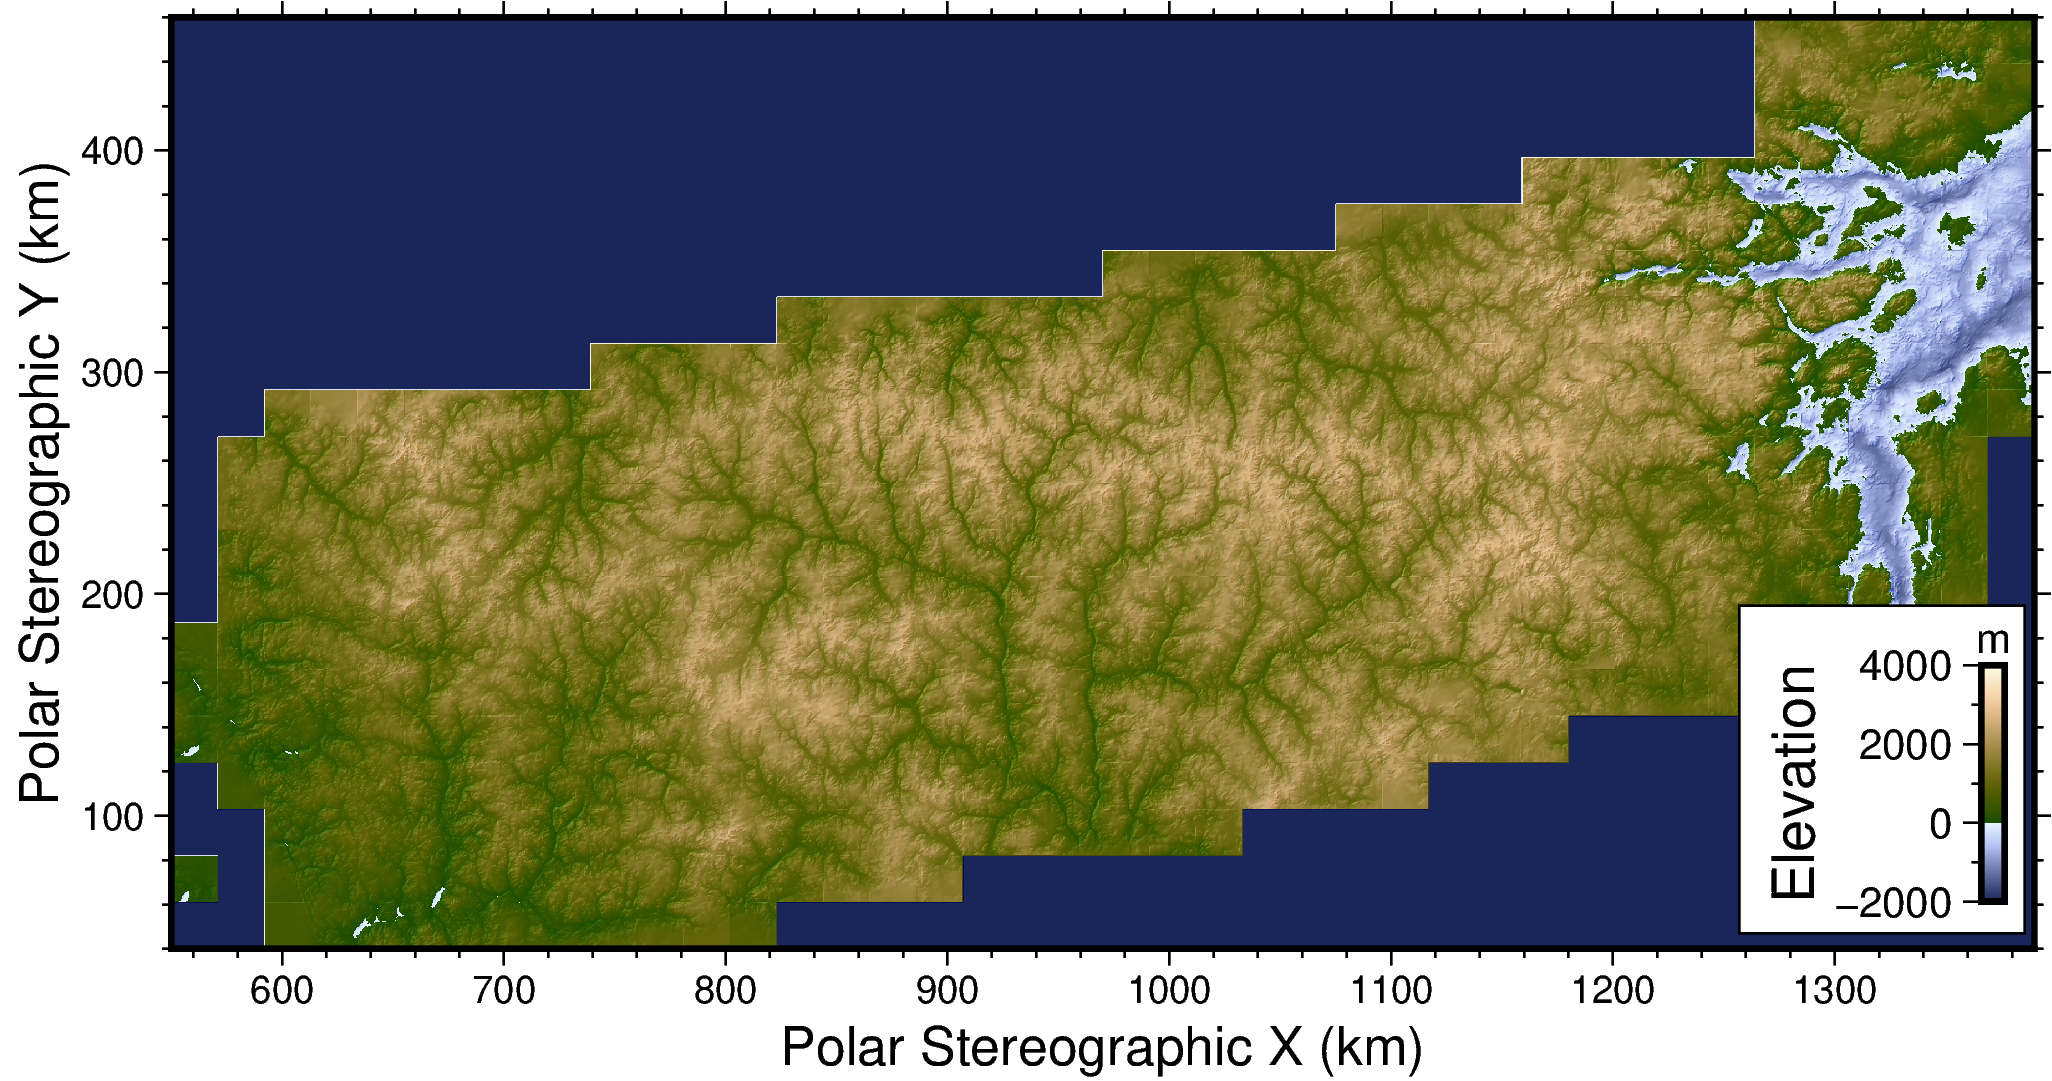

In [27]:
# Show the result

region = [EI_1_region.left, EI_1_region.right, EI_1_region.bottom, EI_1_region.top]
name = 'result_EI_1_1'

fig = gmt.Figure()

rate = 5325

gmt.makecpt(cmap="oleron", series=[-2000, 4000])
fig.grdimage(
        grid=f"{save_file}/result/{name}.tif",
        region=region,
        projection=f"x1:{rate*1000}",
        cmap=True,
        shading="+d",  # default illumination from azimuth -45deg, intensity of +1
        Q=True,
    )

fig.basemap(
        region=[r / 1000 for r in region],
        projection=f"x1:{rate}",
        Bx='af+l"Polar Stereographic X (km)"',
        By='af+l"Polar Stereographic Y (km)"',
        frame=f'WSne+t""',
    )
fig.colorbar(
        position="jBR+jBR+o0.25c/0.4c+w2.0c/0.2c+m",
        box="+gwhite+p0.5p",
        frame=["af", 'x+l"Elevation"', "y+lm"],
        cmap="+Uk",  # kilo-units, i.e. divide by 1000
        S=True,  # no lines inside color scalebar
    )
fig.show()